In [191]:
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.utils import uccsd_generator
import numpy as np

from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from forestopenfermion import exponentiate

import numpy as np
import functools

from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian

In [199]:
sim = WavefunctionSimulator()
numQubit = 4

def solve_vqe(hamiltonian: PauliSum, numQubit) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    numParams = numQubit*(numQubit-1)
    params_init = np.random.rand(numParams)*0.5-0.25
    
    def ansatz_energy(params):
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        
        # Only 'physical' terms in UCC
        #single_amp = []
        #single_amp.append([[0,2], params[0]])
        #single_amp.append([[1,3], params[1]])

        #double_amp = []
        #double_amp.append([[0,1,2,3], params[2]])
        
        # Every possible terms
        single_amp = []
        count = 0
        for i in range(numQubit-1):
            for j in range(i+1, numQubit):
                single_amp.append([[i,j], params[count]])
                count += 1

                
        double_amp = []
        for i in range(numQubit-1):
            for j in range(i+1, numQubit):
                indices = np.arange(numQubit)
                rem = np.setdiff1d(indices, [i, j])
                for ii in range(len(rem)-1):
                    for jj in range(ii+1, len(rem)):
                        double_amp.append([[i,j,rem[ii],rem[jj]], params[count]])
                count += 1
        
        ucc_gen = uccsd_generator(single_amp, double_amp)
        ucc_program = exponentiate(bravyi_kitaev(ucc_gen)/(-1j))
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    params_answer = minimize(ansatz_energy, params_init, method='L-BFGS-B').x
    #print(params_answer)
    return ansatz_energy(params_answer)

In [200]:
def get_ground_energy(interaction_hamil, numQubit):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator(random_seed=1337)
    return solve_vqe(pauliop_hamil, numQubit)


In [201]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy(h2_interaction_hamil, 4)
    vqe_ground_energies.append(ge)
    print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge)


bond length:  0.3  ground state energy:  -0.601803716235789
bond length:  0.4  ground state energy:  -0.9141497081813013
bond length:  0.5  ground state energy:  -1.0551597964437227
bond length:  0.6  ground state energy:  -1.1162860078260601
bond length:  0.7  ground state energy:  -1.1361894534732635
bond length:  0.8  ground state energy:  -1.1341476663383967
bond length:  0.9  ground state energy:  -1.1205602806128137
bond length:  1.0  ground state energy:  -1.101150329272791
bond length:  1.1  ground state energy:  -1.079192934012069
bond length:  1.2  ground state energy:  -1.0567407451126556
bond length:  1.3  ground state energy:  -1.035186265242732
bond length:  1.4  ground state energy:  -1.0154682481409565
bond length:  1.5  ground state energy:  -0.9981493521998176
bond length:  1.6  ground state energy:  -0.9834727280825394
bond length:  1.7  ground state energy:  -0.9714266876181287
bond length:  1.8  ground state energy:  -0.9618169520784324
bond length:  1.9  ground st

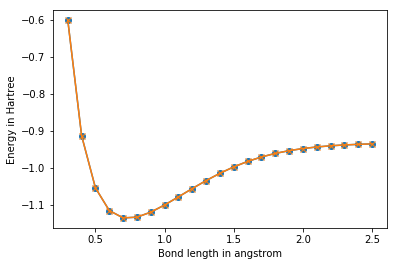

[array(-0.60180372), array(-0.91414971), array(-1.0551598), array(-1.11628601), array(-1.13618945), array(-1.13414767), array(-1.12056028), array(-1.10115033), array(-1.07919294), array(-1.05674075), array(-1.03518627), array(-1.01546825), array(-0.99814935), array(-0.98347273), array(-0.97142669), array(-0.96181695), array(-0.95433885), array(-0.94864111), array(-0.94437468), array(-0.94122403), array(-0.93892239), array(-0.93725495), array(-0.93605492)]
[-0.601803716235789, -0.9141497081813013, -1.0551597964437227, -1.1162860078260601, -1.1361894534732635, -1.1341476663383967, -1.1205602806128137, -1.101150329272791, -1.079192934012069, -1.0567407451126556, -1.035186265242732, -1.0154682481409565, -0.9981493521998176, -0.9834727280825394, -0.9714266876181287, -0.9618169520784324, -0.9543388534413553, -0.9486411106934528, -0.9443746740199517, -0.9412240334119347, -0.9389223855894346, -0.9372549526860435, -0.93605491958378]


In [204]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.1
n_points = 25

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()

    # Print out some results of calculation.
#    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
#        bond_length))
#    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
#    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
#    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
#    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
#        molecule.nuclear_repulsion))
#    for orbital in range(molecule.n_orbitals):
#        print('Spatial orbital {} has energy of {} Hartree.'.format(
#            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'o-')
#plt.plot(bond_lengths, hf_energies, '+-')
plt.plot(bond_lengths, vqe_ground_energies, 'x-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

print(fci_energies)
print(vqe_ground_energies)